# Homework 6 - BYOD - DNN
## Bring Your Own Data - Deep Neural Network

### *Amon Pönitzsch*

### (*8 points total*)


**(a)** First: get some data. You can pick any data source on the internet as long as it fulfills three conditions:

- It is not directly connected to some notebooks analyzing the data. In practice this excludes (!!) e.g. the data sets included in Scikit-Learn,  or at the Kaggle website. But there are many other possible sources on the internet. The best idea is to search for free data download sites related to some topic of your interest.

- the dataset is of tabular nature, i.e. it has columns (features) and rows (individual data points). This excludes datasets consisting of images or continuous text. (Having individual features which are words is fine, just convert them using one-hot encoding.) 

- the dataset has at least five features and at minimum 300 datapoints. More is better. Additionally, there is a categorial target variable (which can be one of the features).

In summary, search for a dataset which has a similar structure as the Titanic dataset. (*3 points*)

Do a test - train split of you data. Use imputation and one-hot encoding where necessary. (*1 point*)

**(b)** Built a deep neural network and train it to classify your data points according to the target variable. Design the network to have  at least one hidden layer. Don"t forget to define the input shape for the first layer and use an activation function for the output layer which allows a probability interpretation. Train the network and plot your training history.  

In case you obtain only poor results: play around with the network architecture and the other hyperparameters. If nothing works: document at least 3 different sets of networks/hyperparameters you tried together with their results. You then obtain still the full points here.  (*3 points*)

**(c)** Discuss your result. Are you overfitting? Any insights from the confusion matrix? (*1 point*)


**ANSWER**

The dataset comes from my Bachelor Thesis. It contains informations for around 1200 galaxies. For each of these galaxies I calculated different parameters (21 in total) which are sorted in "data/new_active_galaxies.csv". My Professor hand-labeled these 1200 galaxies in to different categories, stored in "data/galaxienotes.csv". 
I dont want to categorize the galaxies (since for some categories i dont have enough data), but i want to predict if the galaxie is "variable" or "not variable". 

The parameters store informations like the biggest peak of the fourier trafo, the perdiod duration, the mean value, std etc. The original data are a lightcurves (around 10 years of data), with the Magnitude on y-axes and time on x-axes.



I tried the data with only a combination of dense layers and afterwards with conv1d und maxpool layers. I plottet all of the combinations to see all important data. 

In [41]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt 
import time
import seaborn as sns
from sklearn import metrics
from tqdm import tqdm

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices("GPU")
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(tf.config.list_physical_devices("GPU")) 
tf.random.set_seed(42)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
# load data
def load_data():
    # data prep
    data_X = pd.read_csv("activity_curves/new_active_galaxies.csv")
    
    data_y = pd.read_csv("Lichtkurven/galaxienotes.csv")
    data_y["variable"] = data_y["category"] >= 3 #<- this includes all variable galaxies, everything below a "3" is considered non-variable
    data_y = data_y[["name", "variable"]]

    data_y["variable"] = data_y["variable"].map({True: 1, False: 0})
    data = data_X.merge(data_y, on="name", how="inner")
    data_y = data[["variable"]]

    data.drop(columns=["variable"],inplace = True)

    data = data.infer_objects(copy=False)
    data_X = data.copy()
    data_X.drop(columns=["name"], inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.1, stratify = data_y, random_state=42) # stratify, so the uneven distribution is taken in to account

    scaler = StandardScaler() # is better to normalize 
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test) 
    
    
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    return X_train,X_test,y_train,y_test
X_train,X_test,y_train,y_test = load_data()

In [43]:
from tensorflow.keras.metrics import Recall, Precision,F1Score
def train_model(X_train, y_train, X_test, y_test,layer = [8,32,8] ,batch_size=256, epochs=200,pat=15):

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # shape is 21
    for l in layer:
        if l == max(layer) and l >=5 : # only the biggest layer will have a dropout  
            model.add(Dropout(0.3))
        model.add(Dense(l, activation="relu"))  
    model.add(Dense(1, activation="sigmoid"))    
    #model.summary()
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[Recall()])
    

    class_weights = compute_class_weight( # because the result should be 85% False and 15% true, so its very important to balance the classes -> without the bias is clearly visible in the results
        "balanced", 
        classes=np.unique(y_train), 
        y=y_train    
    )
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,              
                        validation_data=(X_test, y_test),
                        class_weight=class_weight_dict,
                        callbacks=[EarlyStopping(monitor = "val_loss", patience=pat, restore_best_weights=True)])  

    score = model.evaluate(X_test, y_test, verbose=0)

    return model, history, score

def train_advanced_model(X_train, y_train, X_test, y_test,layer = [[["dense",4]]] ,batch_size=256, epochs=200):
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization,Reshape
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    ehm = "before"
    for i,l in enumerate(layer):
        if l[0] == "conv1d":
            if ehm=="before" or ehm == "dense":
                model.add(Reshape((X_train.shape[1], 1)))
                ehm = False
            model.add(Conv1D(l[1], kernel_size=l[2], activation="relu"))
        elif l[0] == "dense":
            model.add(Dense(l[1], activation="relu"))
        elif l[0] == "dropout":
            model.add(Dropout(l[1]))
        elif l[0] == "batchnorm":
            model.add(BatchNormalization())
        elif l[0] == "maxpool":
            model.add(MaxPooling1D(l[1]))
        elif l[0] == "flatten":
            model.add(Flatten())
        ehm = l[0]
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[Recall()])
    

    class_weights = compute_class_weight( 
        "balanced", 
        classes=np.unique(y_train), 
        y=y_train    
    )
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,              
                        validation_data=(X_test, y_test),
                        class_weight=class_weight_dict,
                        callbacks=[EarlyStopping(monitor = "val_loss", patience=15, restore_best_weights=True)])  
    score = model.evaluate(X_test, y_test, verbose=0)

    return model, history, score

In [44]:
# old plot for single model
def plot_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(accuracy))

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

    axes[0].plot(epochs, accuracy, "bo", label="Training")
    axes[0].plot(epochs, val_accuracy, "r", label="Test")
    axes[0].set_xlabel("Epoch", size=18)
    axes[0].set_ylabel("Accuracy", size=18)
    axes[0].legend()
    axes[0].set_title("Accuracy", size=18)

    axes[1].plot(epochs, loss, "bo", label="Training")
    axes[1].plot(epochs, val_loss, "r", label="Test")
    axes[1].set_xlabel("Epoch", size=18)
    axes[1].set_ylabel("Loss", size=18)
    axes[1].set_yscale("log")  
    axes[1].grid()
    axes[1].legend()
    axes[1].set_title("Loss", size=18)

    plt.tight_layout() 
    plt.show()

In [45]:
# old single cn Matrix
def plot_cn_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test,verbose=0)
    binary_predictions = (y_pred >= 0.5).astype(int) 
    cm1 = metrics.confusion_matrix(y_test, binary_predictions,normalize="true")
    sns.heatmap(cm1, annot=True, fmt=".2f", linewidths=.5, square=True, cmap="Blues_r")
    plt.ylabel("true number", size=14)
    plt.xlabel("predicted number", size=14)
    plt.show()

In [46]:
layer_a = [[2,3,2],[3,4,3],[4,16,4],[8,32,8],[16,64,16],[32,128,32],[64,256,64],[128,512,128],[16,4,16]]
layer_b = [[3,4,5],[2,3,4],[3,4,6],[4,8,16],[8,16,32],[16,32,64],[32,64,128],[64,128,256]]
layer_c = [[4,3,2],[3,2],[16,8,4],[32,16,8],[64,32,16],[128,64,32],[256,128,64],[512,256,128],[256,128,64,32],[256,128,64,32,8]]

layer = layer_a + layer_b + layer_c

model = pd.DataFrame(columns=["model","history","acc","loss" "layer","batch_size"])

for l in tqdm(layer):
    m, h, s = train_model(X_train, y_train, X_test, y_test,layer=l ,batch_size=256, epochs=200) #<- I tried different batch_sizes, 256 seemed best
    model = pd.concat([model,pd.DataFrame({"model": [m], "history": [h], "acc": [s[1]], "loss":[s[0]],"layer": [str(l)], "batch_size":[256]})], ignore_index=True)
    
# print("Test loss: {:.4f}".format(score[0]))
# print("Test accuracy: {:.4f}".format(score[1]))

  0%|          | 0/27 [00:00<?, ?it/s]/var/folders/hs/nb4433114mn3n54wdy7jc0lw0000gn/T/ipykernel_20125/1421697705.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model = pd.concat([model,pd.DataFrame({"model": [m], "history": [h], "acc": [s[1]], "loss":[s[0]],"layer": [str(l)], "batch_size":[256]})], ignore_index=True)
100%|██████████| 27/27 [01:52<00:00,  4.18s/it]


In [71]:
def plot_all_history(model,X_test, y_test):
    
    model.sort_values(by=["loss"], ascending=True, inplace=True)

    
    fig, axes = plt.subplots(len(model),3, figsize=(16, len(model["model"])*5), layout="constrained")  
    
    index = 0
    for i,m in model.iterrows():
        his = m["history"]
        keys = list(his.history.keys()) # i have to do this if i wanna switch the metric
        layer = m["layer"]        
        #print(keys)
        accuracy = his.history[keys[1]]  
        val_accuracy = his.history[keys[3]]
        loss = his.history["loss"]
        val_loss = his.history["val_loss"]
        epochs = range(len(accuracy))
        # ====== ACC PLOT ========
        ax = axes.flatten()[index]  
        ax.plot(epochs, accuracy, "o-", label=f"Training-acc")
        ax.plot(epochs, val_accuracy, "o-", label=f"Test-acc")
        ax.set_title(f"ACC: {m['acc']:.4f} and LOSS: {m['loss']:.4f},BS:{m['batch_size']}",loc="left")
        ax.legend()
        ax.grid(True)
        # ====== LOSS PLOT ========
        index += 1
        ax = axes.flatten()[index] 
        ax.plot(epochs, loss, "o-", label=f"Training-loss")
        ax.plot(epochs, val_loss, "o-", label=f"Test-loss")
        ax.set_title(f"with Layer: {layer}")
        ax.legend()
        ax.grid(True)
        # ====== MATRIX PLOT ========
        index += 1
        ax = axes.flatten()[index] 
        y_pred = m["model"].predict(X_test,verbose=0)
        binary_predictions = (y_pred >= 0.5).astype(int) 
        cm1 = metrics.confusion_matrix(y_test, binary_predictions,normalize="true")
        sns.heatmap(cm1, annot=True, fmt=".2f", linewidths=.5, square=True, cmap="Blues_r",ax=ax)
        ax.set_ylabel("true number", size=14)
        ax.set_xlabel("predicted number", size=14)
        index += 1
    
    plt.show()
    


['loss', 'recall_26', 'val_loss', 'val_recall_26']
['loss', 'recall_24', 'val_loss', 'val_recall_24']
['loss', 'recall_25', 'val_loss', 'val_recall_25']
['loss', 'recall_19', 'val_loss', 'val_recall_19']
['loss', 'recall_22', 'val_loss', 'val_recall_22']
['loss', 'recall_4', 'val_loss', 'val_recall_4']
['loss', 'recall_23', 'val_loss', 'val_recall_23']
['loss', 'recall_21', 'val_loss', 'val_recall_21']
['loss', 'recall_9', 'val_loss', 'val_recall_9']
['loss', 'recall_20', 'val_loss', 'val_recall_20']
['loss', 'recall_5', 'val_loss', 'val_recall_5']
['loss', 'recall_12', 'val_loss', 'val_recall_12']
['loss', 'recall_8', 'val_loss', 'val_recall_8']
['loss', 'recall_13', 'val_loss', 'val_recall_13']
['loss', 'recall_15', 'val_loss', 'val_recall_15']
['loss', 'recall_7', 'val_loss', 'val_recall_7']
['loss', 'recall_3', 'val_loss', 'val_recall_3']
['loss', 'recall_10', 'val_loss', 'val_recall_10']
['loss', 'recall_14', 'val_loss', 'val_recall_14']
['loss', 'recall_16', 'val_loss', 'val_reca

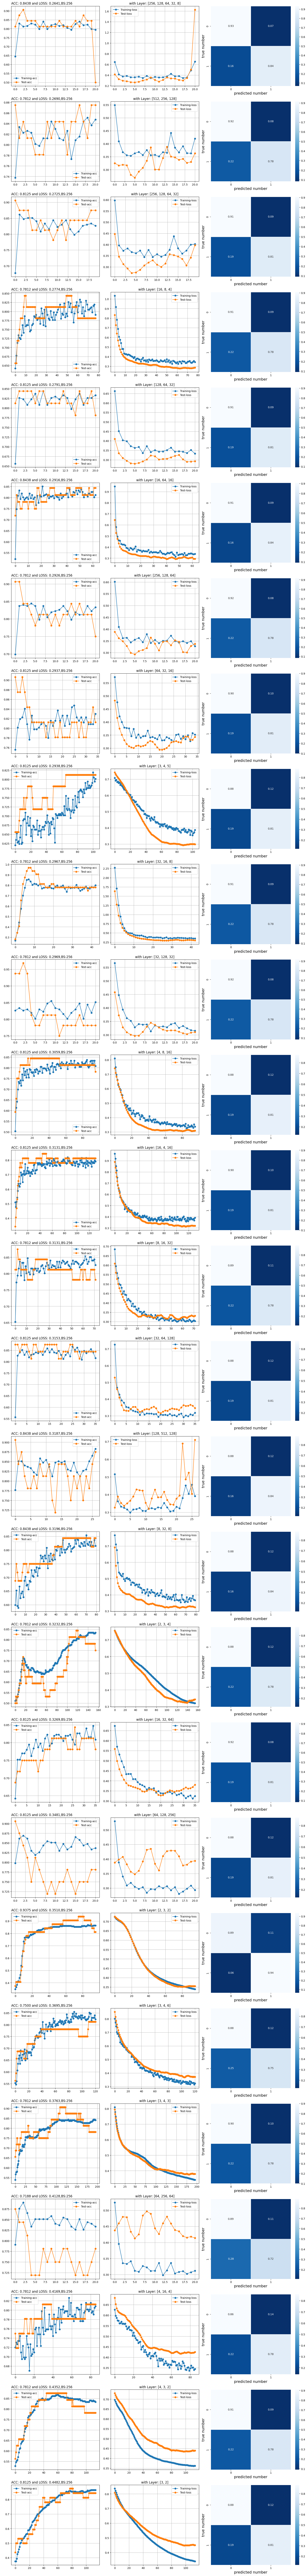

In [72]:
plot_all_history(model,X_test=X_test, y_test=y_test)
# best LOSS on Top -> not best layer config

Smaller numbers ([16,8,4] etc. ) get better results then big numbers. I cant really find a difference between the order of the numbers. But more hidden layers do not bring a better result, 2-3 is the optimal amount from the test runs. 
Since i have a very biased problem, the cn Matrix is very important. And a better Loss/acc does not automatically mean, that the predictions are better. It is a very good indicater tho. 

In some cases overfitting is happening, thats the case when the value for the test data gets worse then for the train data. Models with huge parameters sizes are overfitting way faster. Since i stored the best loss value but continued for a bit longer, you can see, that the bigger  models have a huge drop right at the beginning, but then get way worse. So even tho the pictures are sorted by the loss, that does not mean that these layer configurations are actually the best. 

This model is a different approach and it also works. It is not optimized, so its hard to compare. Since I expected it to be more usefull for pictures, I will not go into more detail with this version.

In [73]:


layer = [[["conv1d",4,3],["maxpool",2],["conv1d",4,3],["flatten",None],["dense",4]],[["conv1d",4,6],["maxpool",2],["conv1d",4,6],["flatten",None],["dense",4]],[["conv1d",16,3],["maxpool",4],["conv1d",16,3],["flatten",None],["dense",8]],
         [["conv1d",16,3],["maxpool",2],["conv1d",4,3],["flatten",None],["dense",8]],[["conv1d",16,3],["conv1d",16,3],["flatten",None],["dense",8]],[["conv1d",6,3],["conv1d",12,2],["flatten",None],["dense",4]],[["conv1d",12,3],["conv1d",24,2],["flatten",None],["dense",8]],
         [["conv1d",2,3],["conv1d",4,2],["flatten",None],["dense",2]],[["conv1d",6,3],["conv1d",12,2],["conv1d",40,2],["flatten",None],["dense",8],["dense",4]],[["conv1d",40,3],["conv1d",12,2],["conv1d",6,2],["flatten",None],["dense",2]]]
batch_s = [128,256,16,64,512,31,16,32,64,32]
model2 = pd.DataFrame(columns=["model","history","acc","loss" "layer","batch_size"])

for l,bs in tqdm(zip(layer,batch_s)):
    m, h, s = train_advanced_model(X_train, y_train, X_test, y_test,layer=l ,batch_size=bs, epochs=200)
    model2 = pd.concat([model2,pd.DataFrame({"model": [m], "history": [h], "acc": [s[1]], "loss":[s[0]],"layer": [str(l)],"batch_size":[bs]})], ignore_index=True)
    

10 10


0it [00:00, ?it/s]/var/folders/hs/nb4433114mn3n54wdy7jc0lw0000gn/T/ipykernel_20125/567952409.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model2 = pd.concat([model2,pd.DataFrame({"model": [m], "history": [h], "acc": [s[1]], "loss":[s[0]],"layer": [str(l)],"batch_size":[bs]})], ignore_index=True)
10it [01:21,  8.12s/it]


['loss', 'recall_33', 'val_loss', 'val_recall_33']
['loss', 'recall_32', 'val_loss', 'val_recall_32']
['loss', 'recall_35', 'val_loss', 'val_recall_35']
['loss', 'recall_28', 'val_loss', 'val_recall_28']
['loss', 'recall_36', 'val_loss', 'val_recall_36']
['loss', 'recall_29', 'val_loss', 'val_recall_29']
['loss', 'recall_31', 'val_loss', 'val_recall_31']
['loss', 'recall_34', 'val_loss', 'val_recall_34']
['loss', 'recall_30', 'val_loss', 'val_recall_30']
['loss', 'recall_27', 'val_loss', 'val_recall_27']


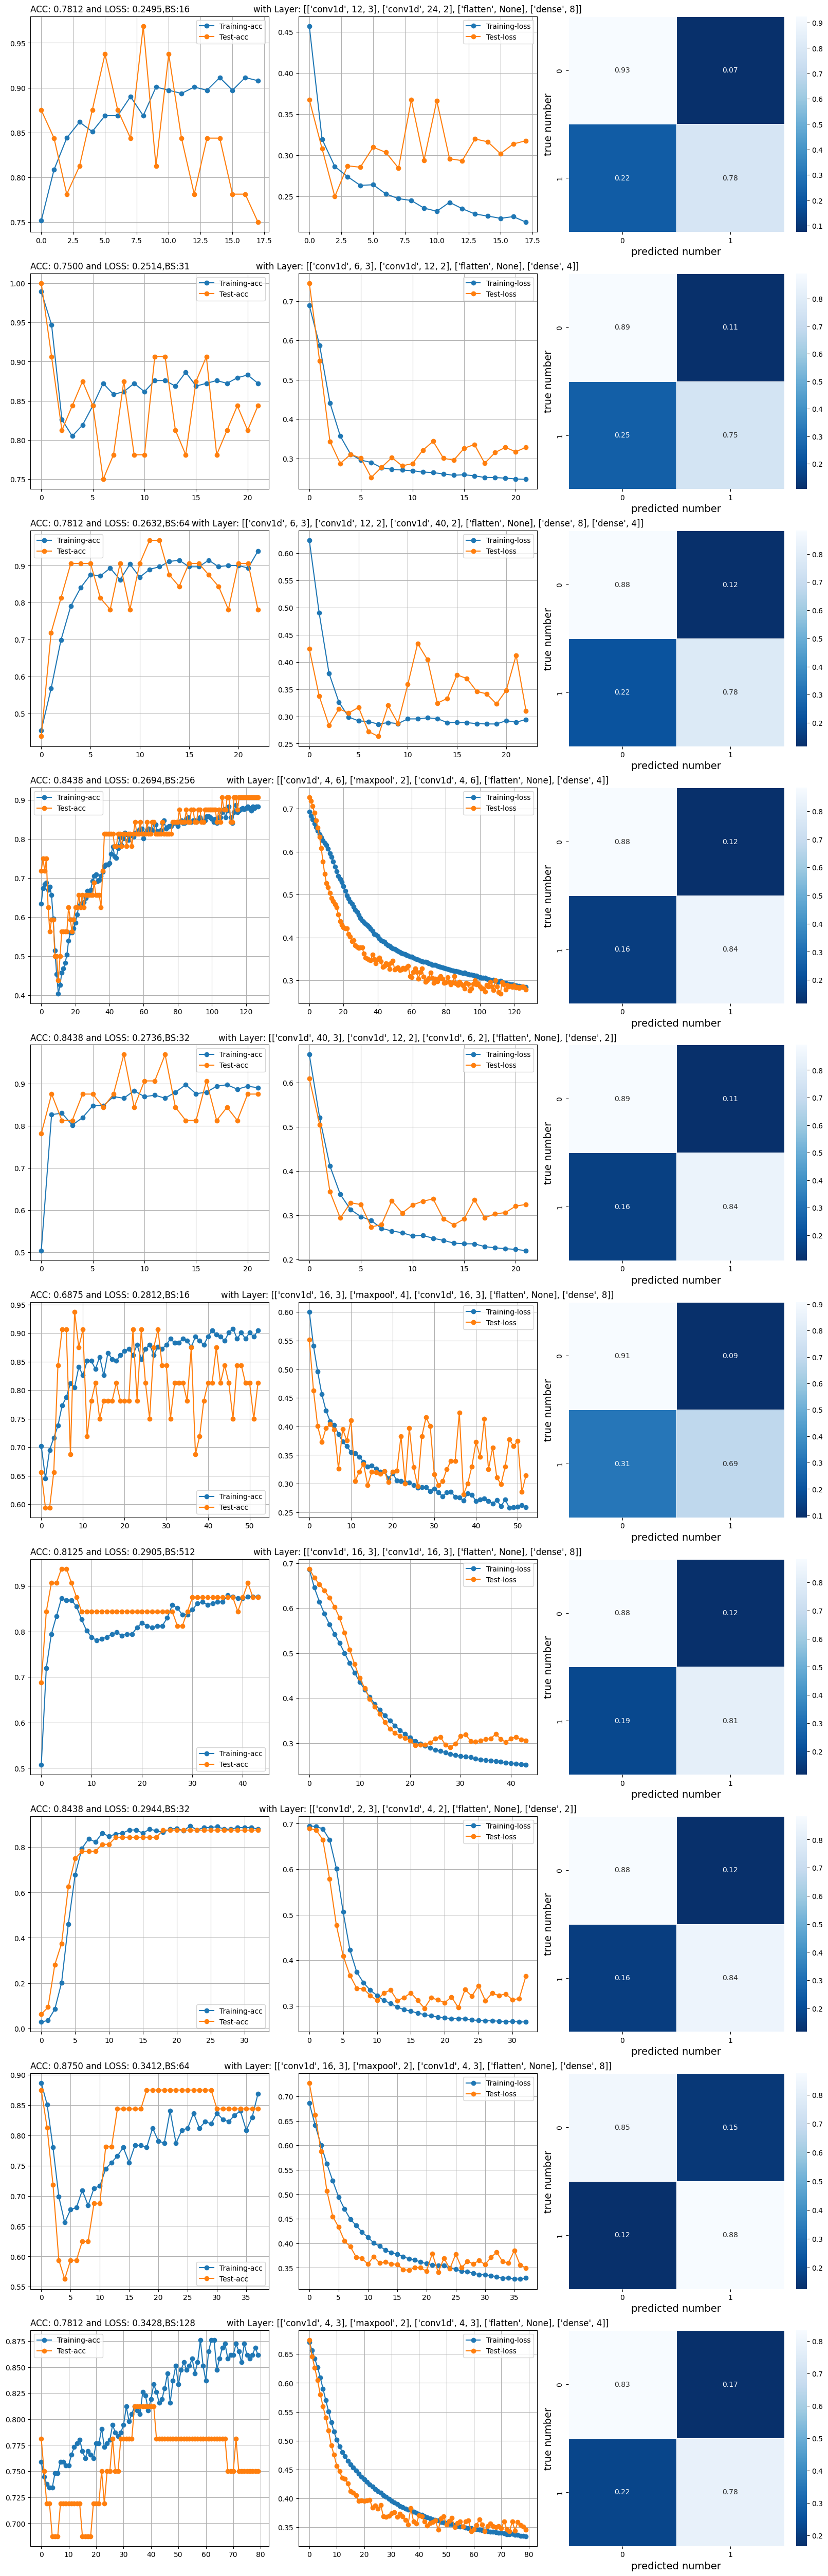

In [74]:
plot_all_history(model2,X_test=X_test, y_test=y_test)


We can see, that a model with a different structure also works well, even better then the structures tested before (not for the recall metric). Small batch sizes seem to overfit way more then big batch sizes.

In [ ]:
#model_test, history_test, score_test = train_model(X_train, y_train, X_test, y_test,layer=[4096,2048,1024,512,256,128,64,32,16,8,4,2] ,batch_size=256, epochs=1000,pat=500)
#model_test, history_test, score_test = train_model(X_train, y_train, X_test, y_test,layer=[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096] ,batch_size=256, epochs=1000,pat=500)
model_test, history_test, score_test = train_model(X_train, y_train, X_test, y_test,layer=[4,3,2] ,batch_size=128, epochs=1000,pat=500)

print(f"Score: acc: {score_test[1]} loss: {score_test[0]}")

Score: acc: 0.8552631735801697 loss: 0.3635128438472748


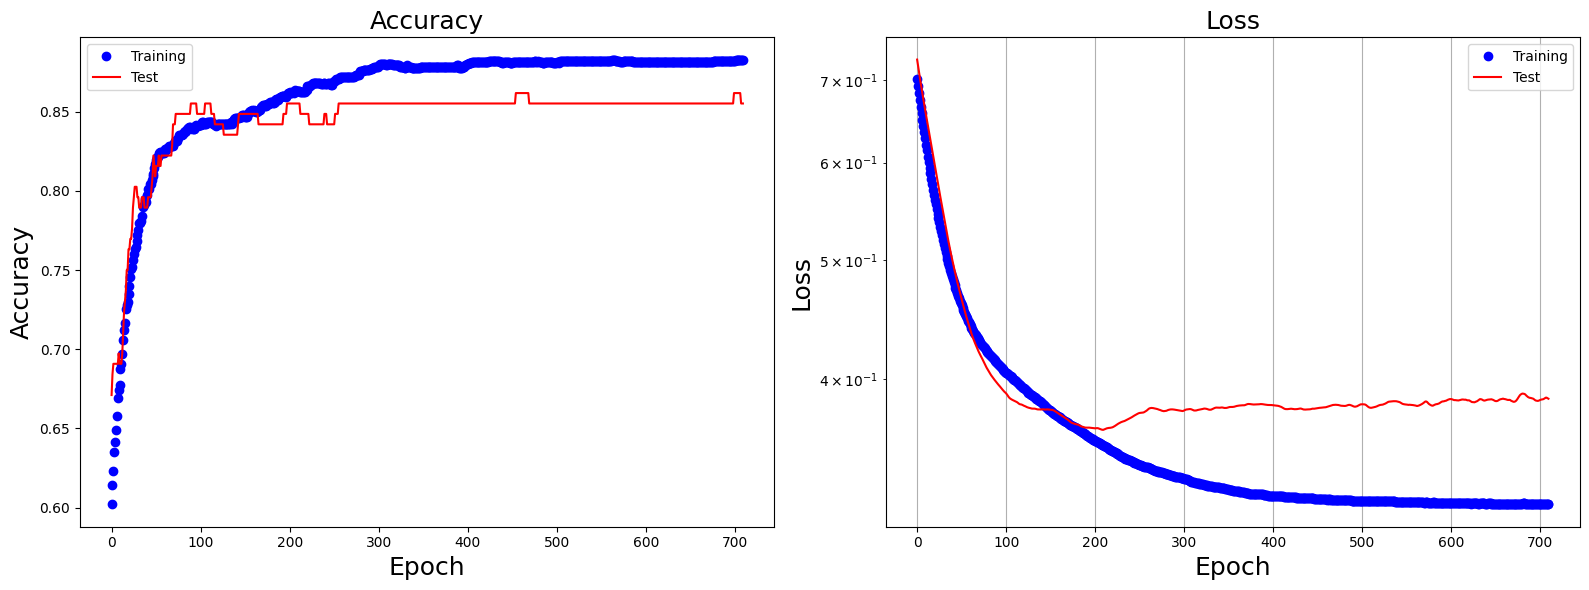

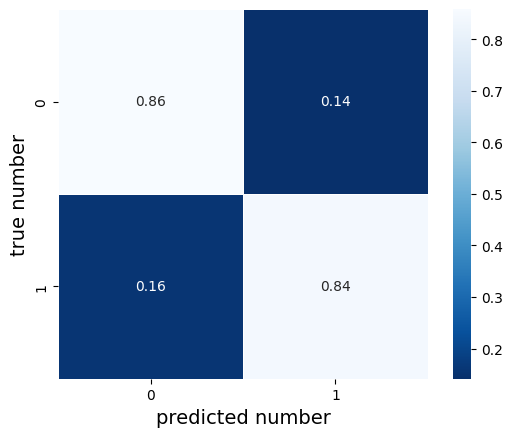

In [ ]:
plot_history(history_test)
plot_cn_matrix(model_test, X_test, y_test)
